In [10]:
# %pip install pyhrv==0.4.1
# %pip install biosppy
# %pip install matplotlib
# %pip install numpy
# %pip install scipy
# %pip install nolds
# %pip install spectrum
# %pip install OpenSignalsReader
# %pip install pandas


In [11]:
# command to view figures in Jupyter notebook
%matplotlib inline 

# import plotting module 
import matplotlib.pyplot as plt 
import japanize_matplotlib


# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 18   # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 20   # fontsize for figure titles
plt.rcParams['font.size'] = 16        # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.6 # line width for plotting
plt.rcParams['axes.unicode_minus'] = False    # マイナス記号の文字化け防止


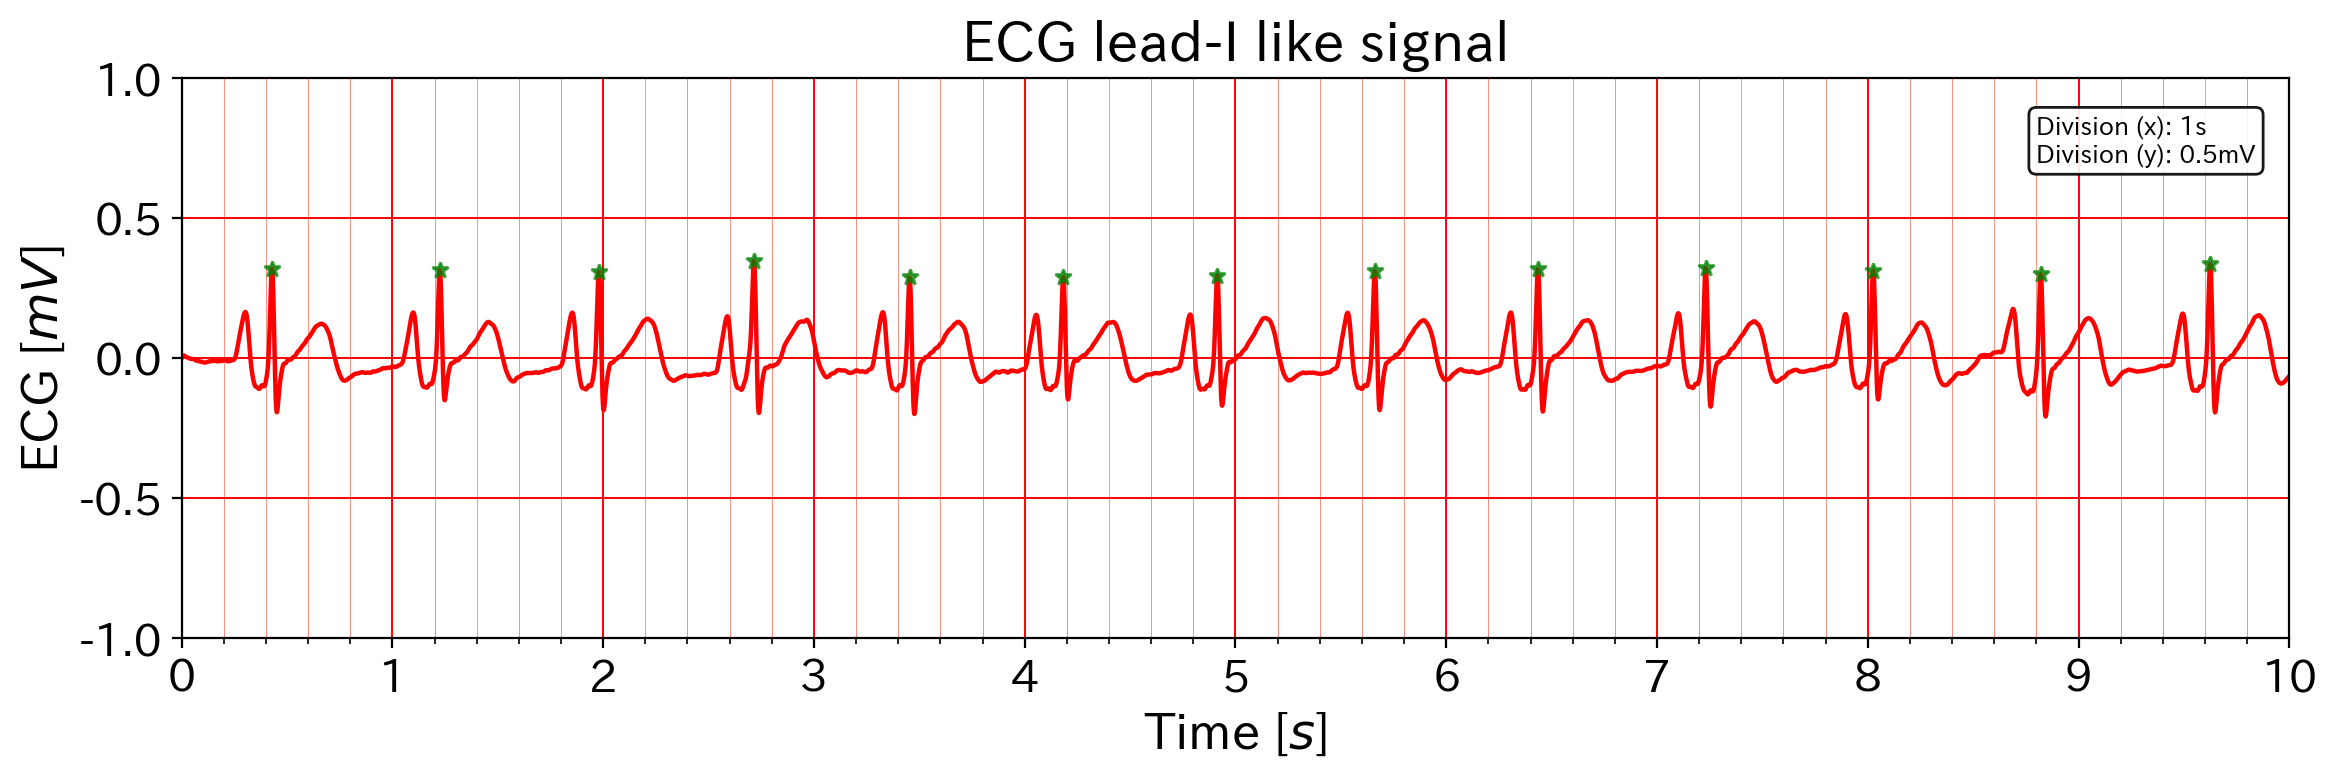

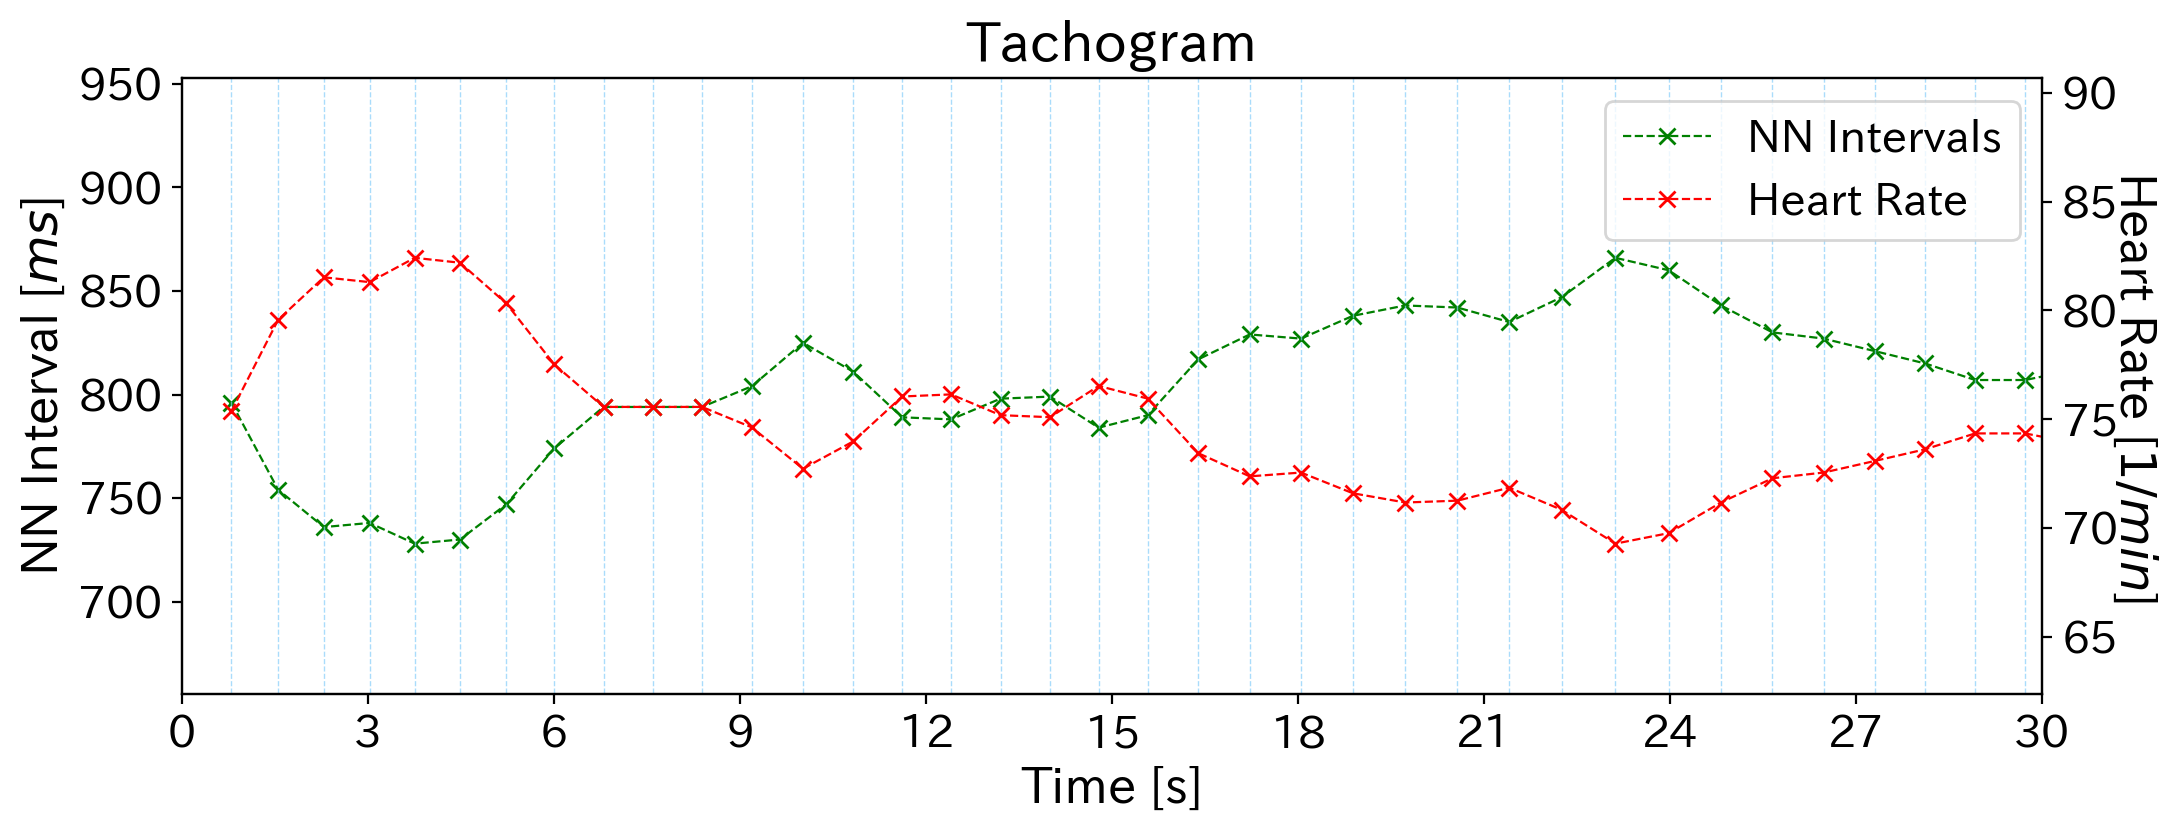

ReturnTuple(tachogram_plot=<Figure size 1200x400 with 2 Axes>)

In [12]:
import pyhrv.tools as tools
import biosppy
import numpy as np
import pyhrv.tools as tools
from opensignalsreader import OpenSignalsReader

# Load sample ECG signal & extract R-peaks using BioSppy
import pandas as pd
file = "/Users/gotokenichiro/Rits/2024AW/知能情報学実験/heart_beat/data/ess3/calculating_data.csv"
signal_ecg = pd.read_csv(file, skiprows=None, header=None)
t, signal, rpeaks = biosppy.signals.ecg.ecg(signal=signal_ecg[0], sampling_rate=1000, show=False, interactive=False)[:3]
signal = (signal/1000)*1000 #ゲインで1000倍（1mv/V）しているため1000で割る（V)→ 1000倍して mVに

# Plot the ECG signal (interval: 0s to 10s)
tools.plot_ecg(signal, sampling_rate=1000, interval=[0, 10])

# Compute NNI(=RRI)
nni = tools.nn_intervals(rpeaks=t[rpeaks])

# Plot the Tachogram of the ECG signal (interval: 0s to 30s)
tools.tachogram(nni=nni, sampling_rate=1000, interval=[0, 30])

#print(nni)


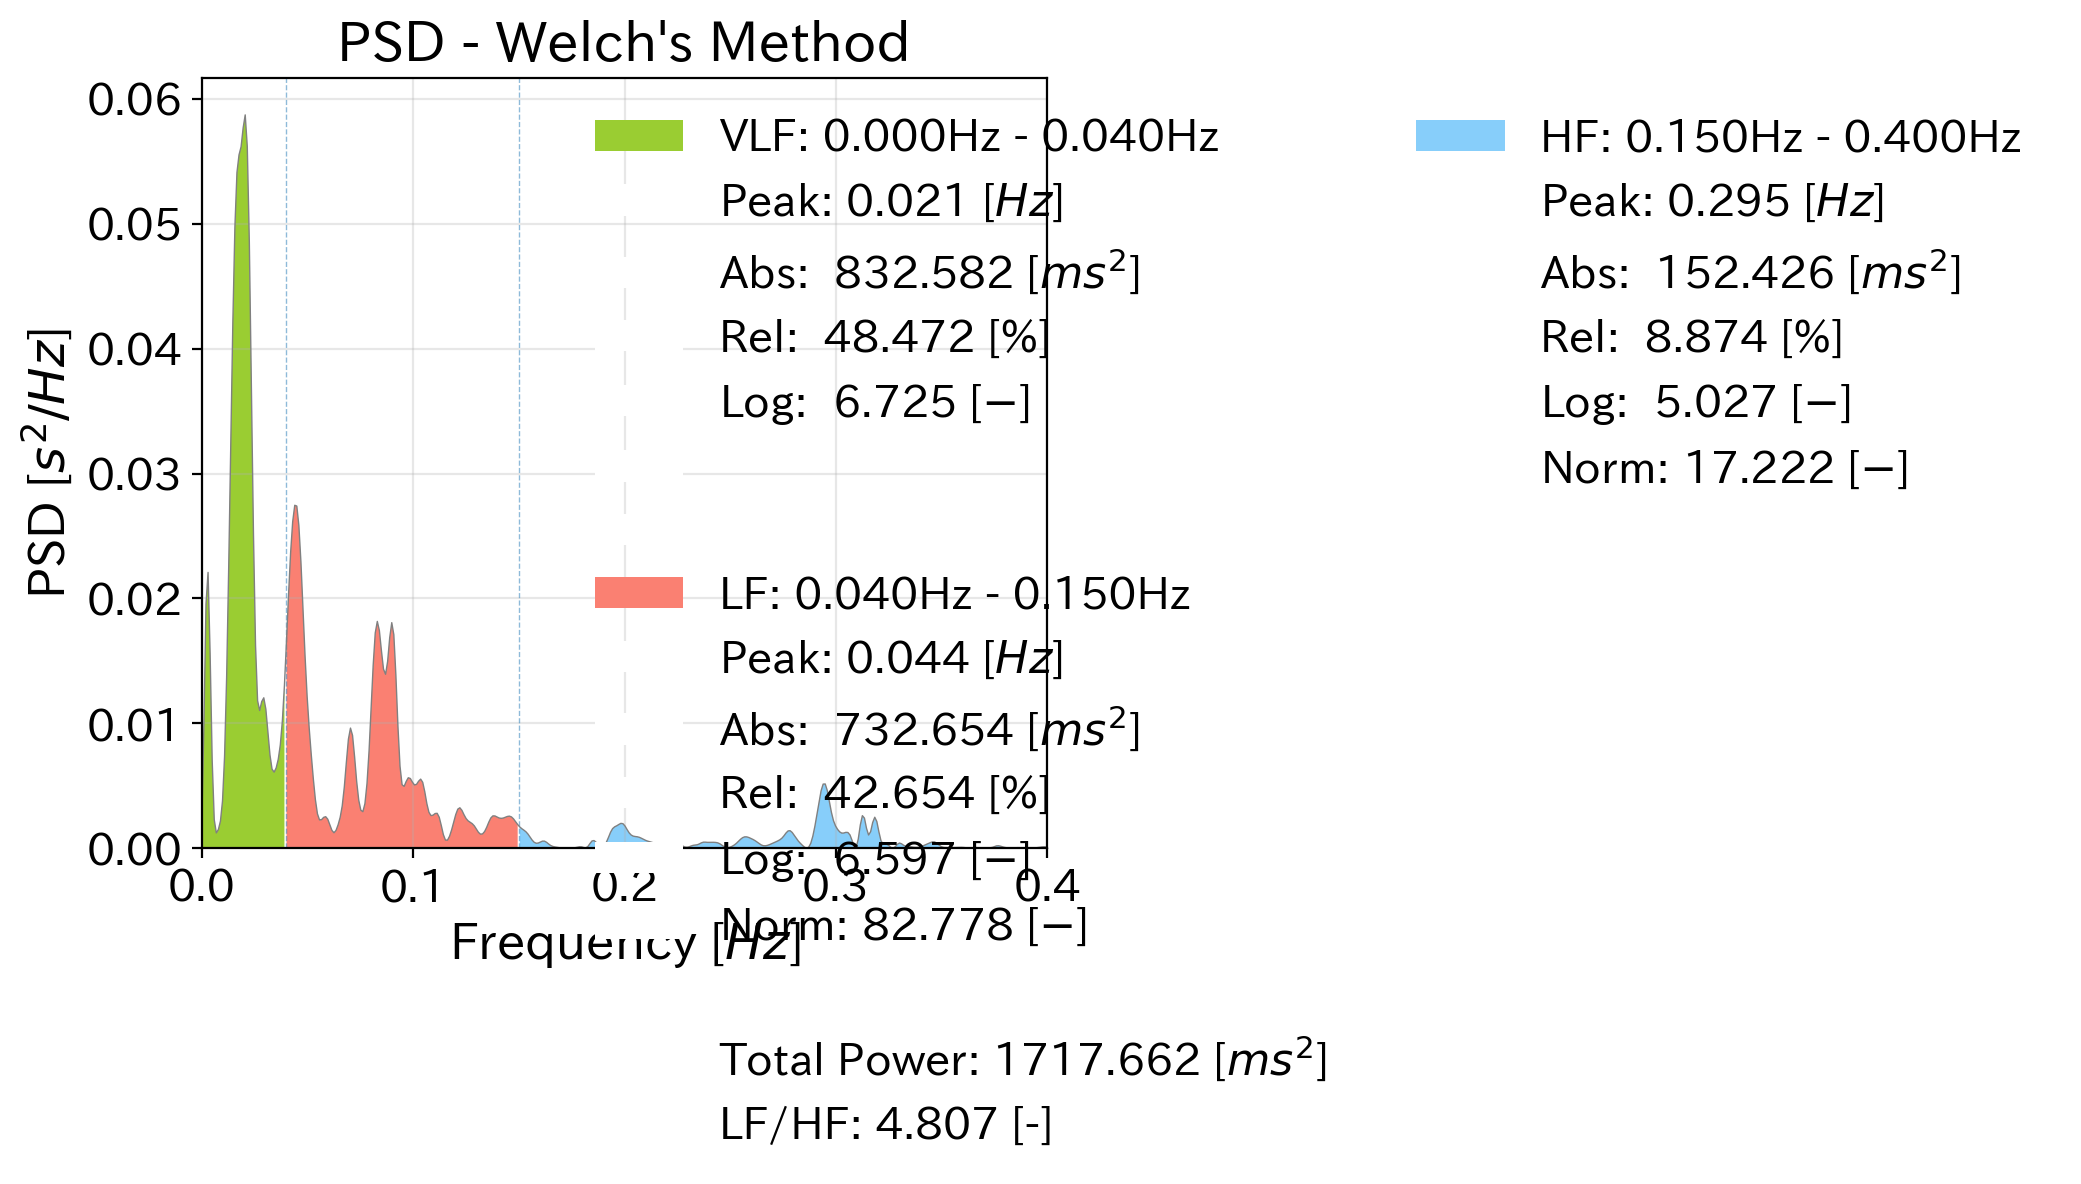

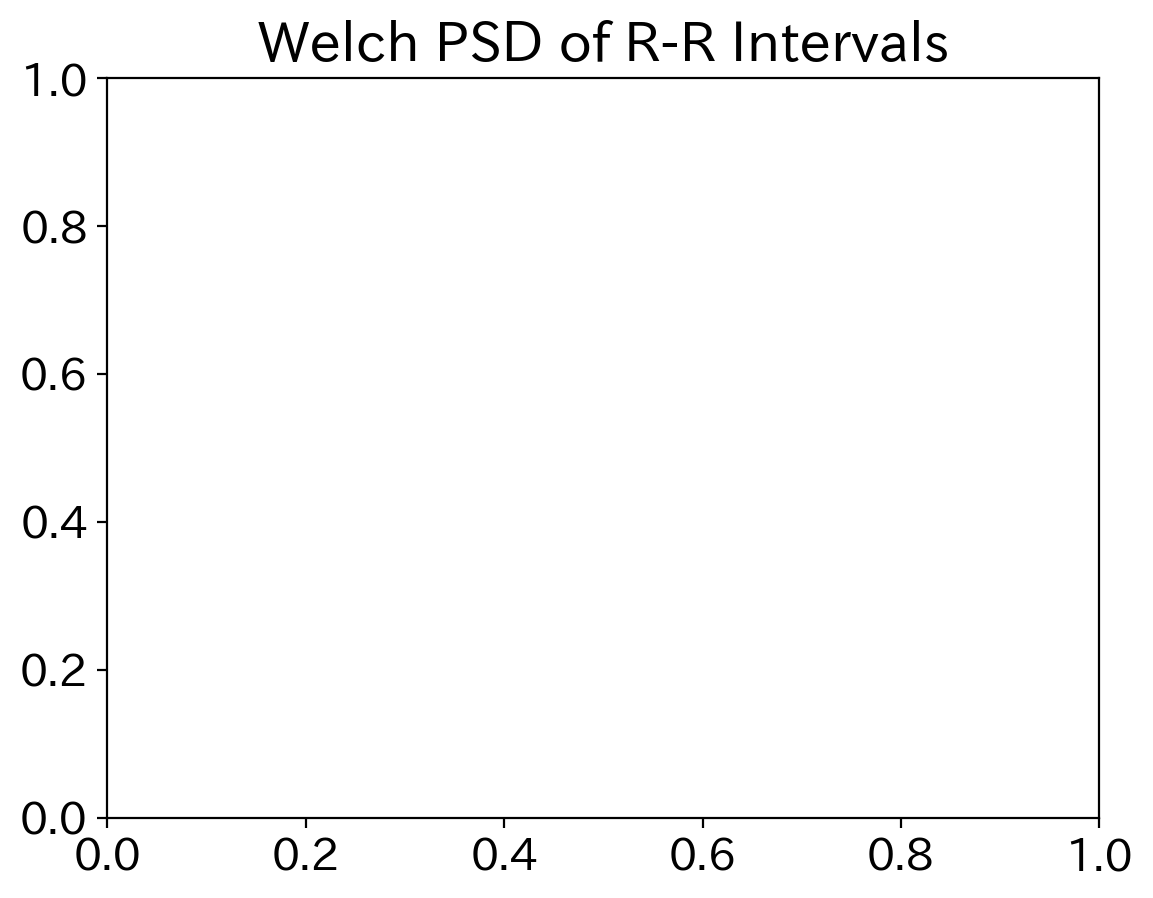

ReturnTuple(fft_bands=ReturnTuple(ulf=None, vlf=(0.0, 0.04), lf=(0.04, 0.15), hf=(0.15, 0.4)), fft_peak=(np.float64(0.0205078125), np.float64(0.0439453125), np.float64(0.294921875)), fft_abs=(np.float64(832.5824247655735), np.float64(732.6538048919537), np.float64(152.42621161957135)), fft_rel=(np.float64(48.471830364209424), np.float64(42.65412034900283), np.float64(8.874049286787747)), fft_log=(6.724532225680974, 6.596673291398814, 5.026680620717979), fft_norm=(np.float64(82.77825634112185), np.float64(17.221743658878164)), fft_ratio=np.float64(4.8066129644455575), fft_total=np.float64(1717.6624412770984), fft_plot=<Figure size 1200x500 with 2 Axes>, fft_nfft=4096, fft_window='hamming', fft_resampling_frequency=4, fft_interpolation='cubic')


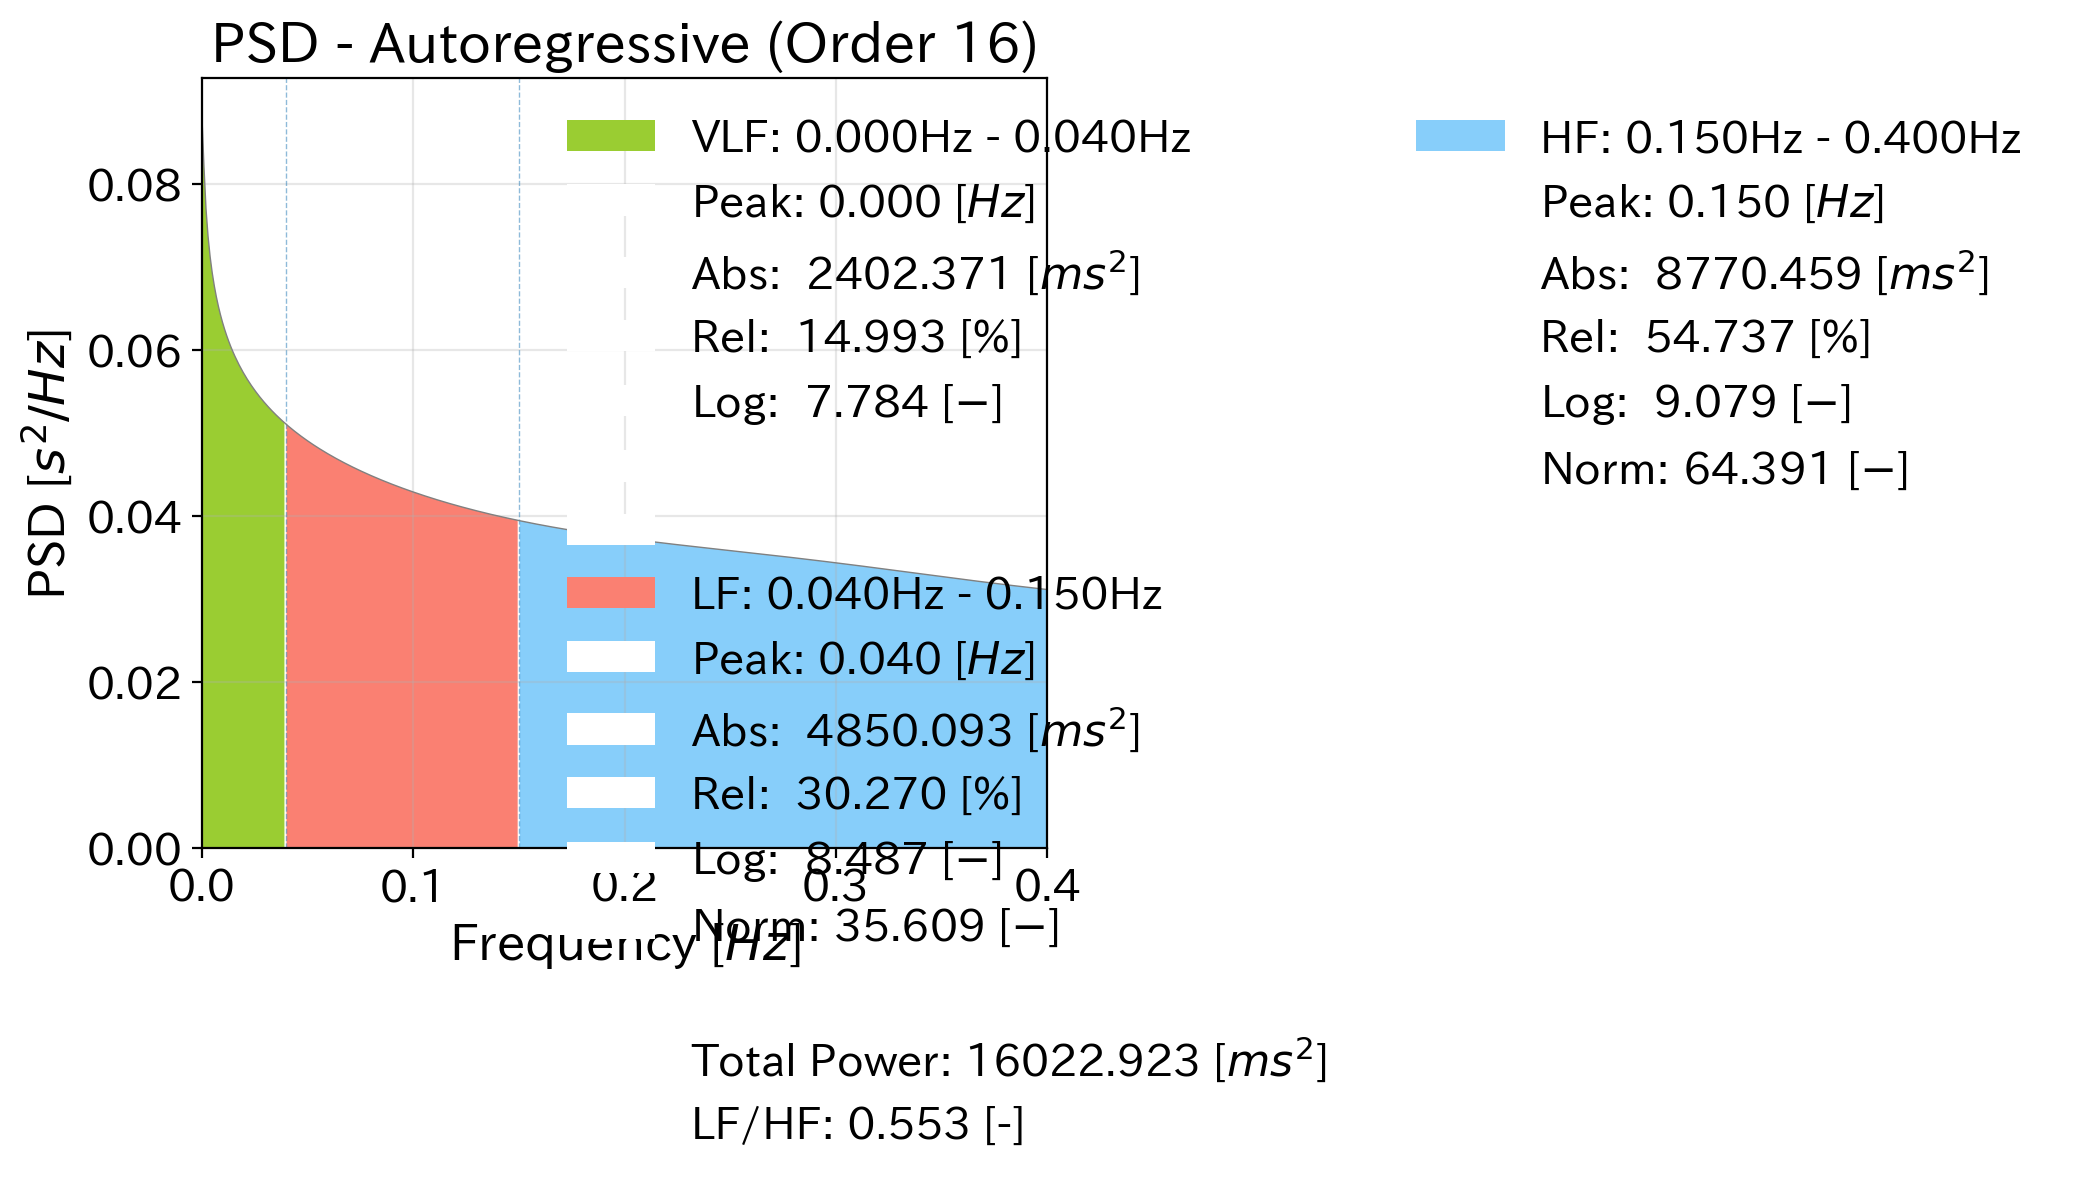

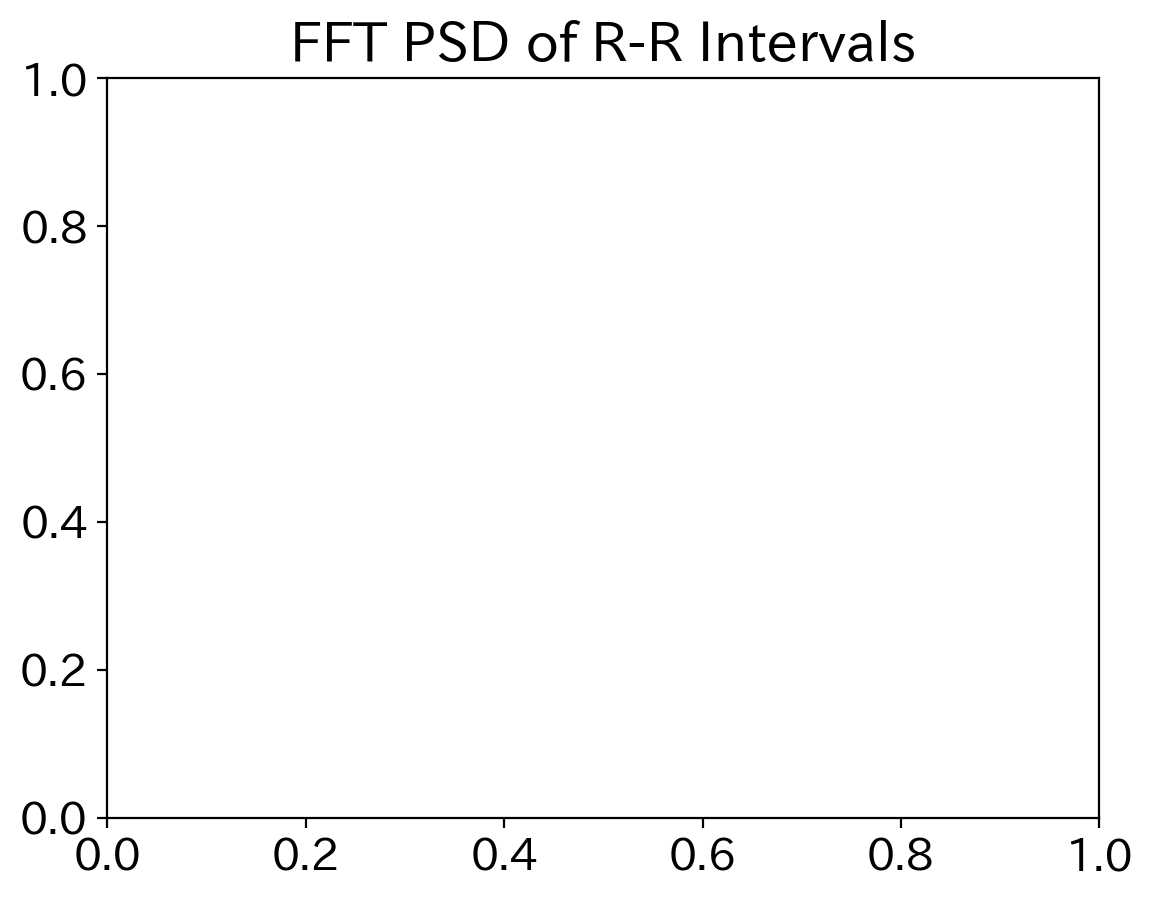

ReturnTuple(ar_bands=ReturnTuple(ulf=None, vlf=(0.0, 0.04), lf=(0.04, 0.15), hf=(0.15, 0.4)), ar_peak=(np.float64(0.0), np.float64(0.0400390625), np.float64(0.150390625)), ar_abs=(np.float64(2402.37114090831), np.float64(4850.093244176579), np.float64(8770.45894601066)), ar_rel=(np.float64(14.993338551686438), np.float64(30.269715107255397), np.float64(54.73694634105816)), ar_log=(7.78421150398804, 8.486753209350137, 9.079144415355104), ar_norm=(np.float64(35.60863888962424), np.float64(64.39136111037577)), ar_ratio=np.float64(0.5530033575247163), ar_total=np.float64(16022.92333109555), ar_nfft=4096, ar_order=16, ar_resampling_frequency=4, ar_interpolation='cubic', ar_plot=<Figure size 1200x500 with 2 Axes>)


In [13]:
import pyhrv.frequency_domain as fd
import matplotlib.pyplot as plt

# nni（ms単位のRR間隔）のリストを取得済みとする
# ここではあなたのコードで nni = tools.nn_intervals(rpeaks=t[rpeaks]) がそれに相当

# --- Welch’s Method で解析する場合 ---
# show=Trueにすると自動でプロットしてくれる
results_welch = fd.welch_psd(nni=nni, show=True)
plt.title("Welch PSD of R-R Intervals")
plt.show()

# 周波数領域の結果が入っている
print(results_welch)

# --- シンプルに FFT で解析する場合(内部でやってくれる) ---
results_fft = fd.ar_psd(nni=nni, show=True)
plt.title("FFT PSD of R-R Intervals")
plt.show()

print(results_fft)


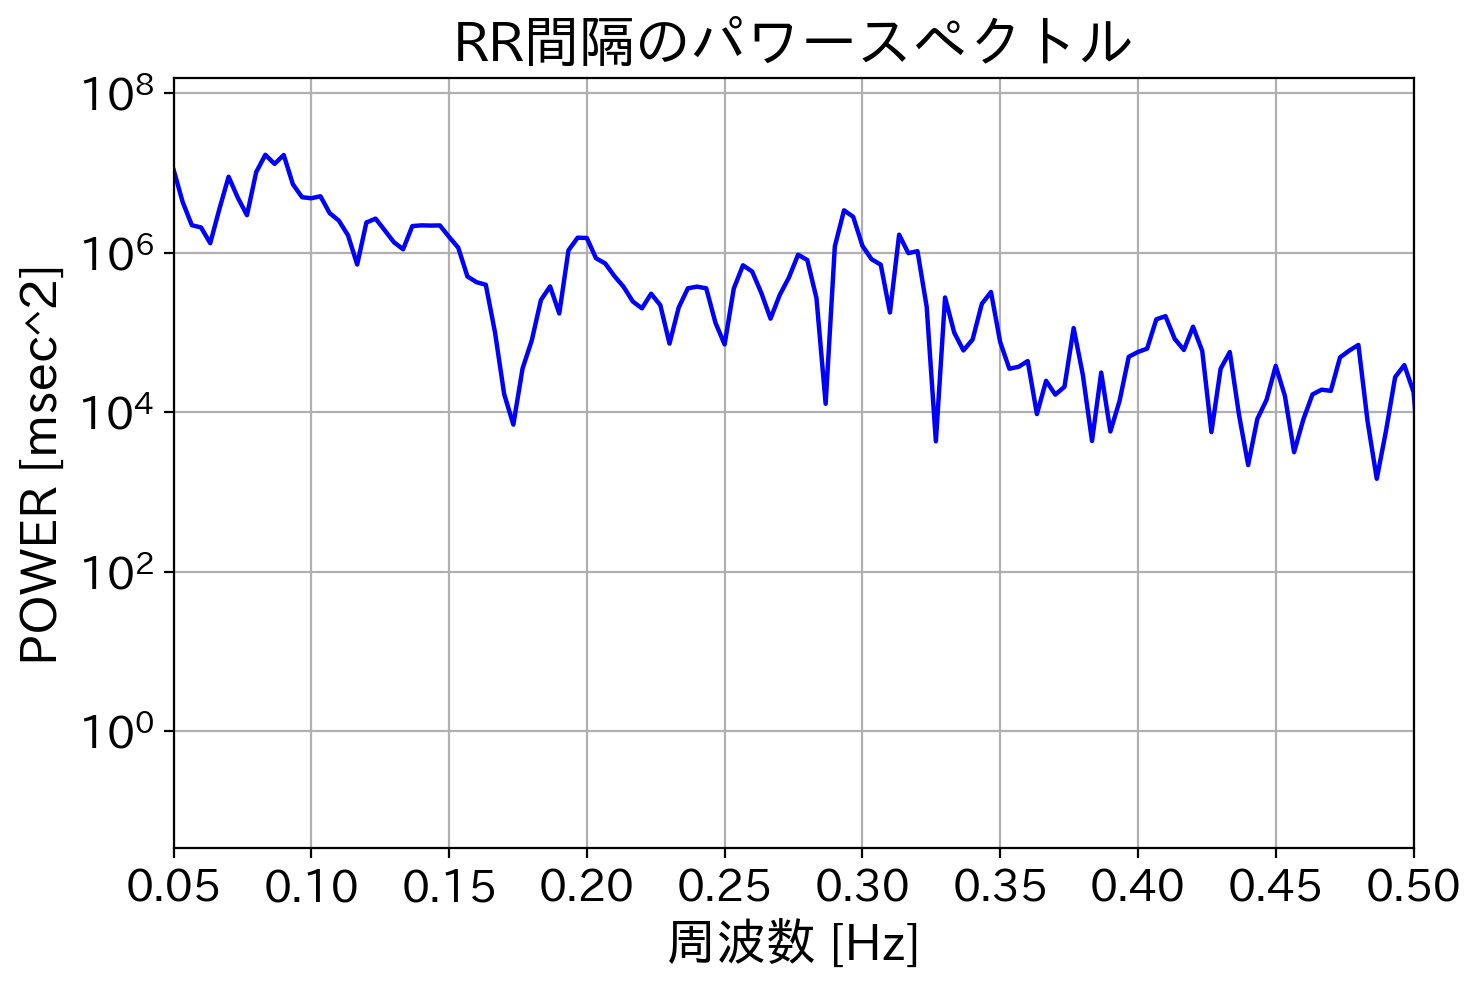

In [14]:
# RRIをFFT解析してみる
nni_ms = np.array(nni, dtype=float)

# 各RR間隔の終了時点の累積時間 [秒] (時系列にする)
time_sec = np.cumsum(nni_ms) / 1000.0

# ---------------------------------------------------------------------
# 2) 等間隔サンプリング (リサンプリング)
#    FFTは本来「等間隔サンプリングされた時系列」が前提だから
#    ここでは 4 Hz (4サンプル/秒) にしているが、用途に応じて変更可
# ---------------------------------------------------------------------
fs = 4.0  # リサンプリング周波数 [Hz]
time_resample = np.arange(time_sec[0], time_sec[-1], 1.0/fs)

# 線形補間
nni_resampled = np.interp(time_resample, time_sec, nni_ms)

# ---------------------------------------------------------------------
# 3) 解析にかける前処理 (平均を引いてDC成分除去、窓関数など)
# ---------------------------------------------------------------------
# DC成分除去
nni_resampled -= np.mean(nni_resampled)

# 窓関数 (ハミング窓) をかける (要不要は好み)
windowed = np.hamming(len(nni_resampled)) * nni_resampled

# ---------------------------------------------------------------------
# 4) FFT をかけてパワースペクトルを計算
# ---------------------------------------------------------------------
N = len(windowed)
fft_data = np.fft.rfft(windowed)            # 実数信号なので rfft
freqs = np.fft.rfftfreq(N, d=1.0/fs)        # 周波数軸
power_spectrum = np.abs(fft_data)**2        # パワースペクトル (振幅^2)

# power_spectrum はミリ秒^2 のスケール

# ---------------------------------------------------------------------
# 5) プロット (例: y 軸はログスケールにしてみる)
# ---------------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(freqs, power_spectrum, color='blue')
plt.yscale('log')  # 場合によってはリニアスケールでもOK
plt.xlim([0.05, 0.5]) # HRVでは 0.4~0.5 Hz くらいまでを見ることが多い
plt.xlabel('周波数 [Hz]')
plt.ylabel('POWER [msec^2]')
plt.title('RR間隔のパワースペクトル')
plt.grid(True)
plt.show()


In [15]:
# Import packages
import numpy as np
import pyhrv
import pyhrv.time_domain as td

# Load NNI sample series

# Compute SDNN
result = td.sdnn(nni)

# Access SDNN value using the key 'sdnn'
print(result['sdnn'])


35.955486269381744


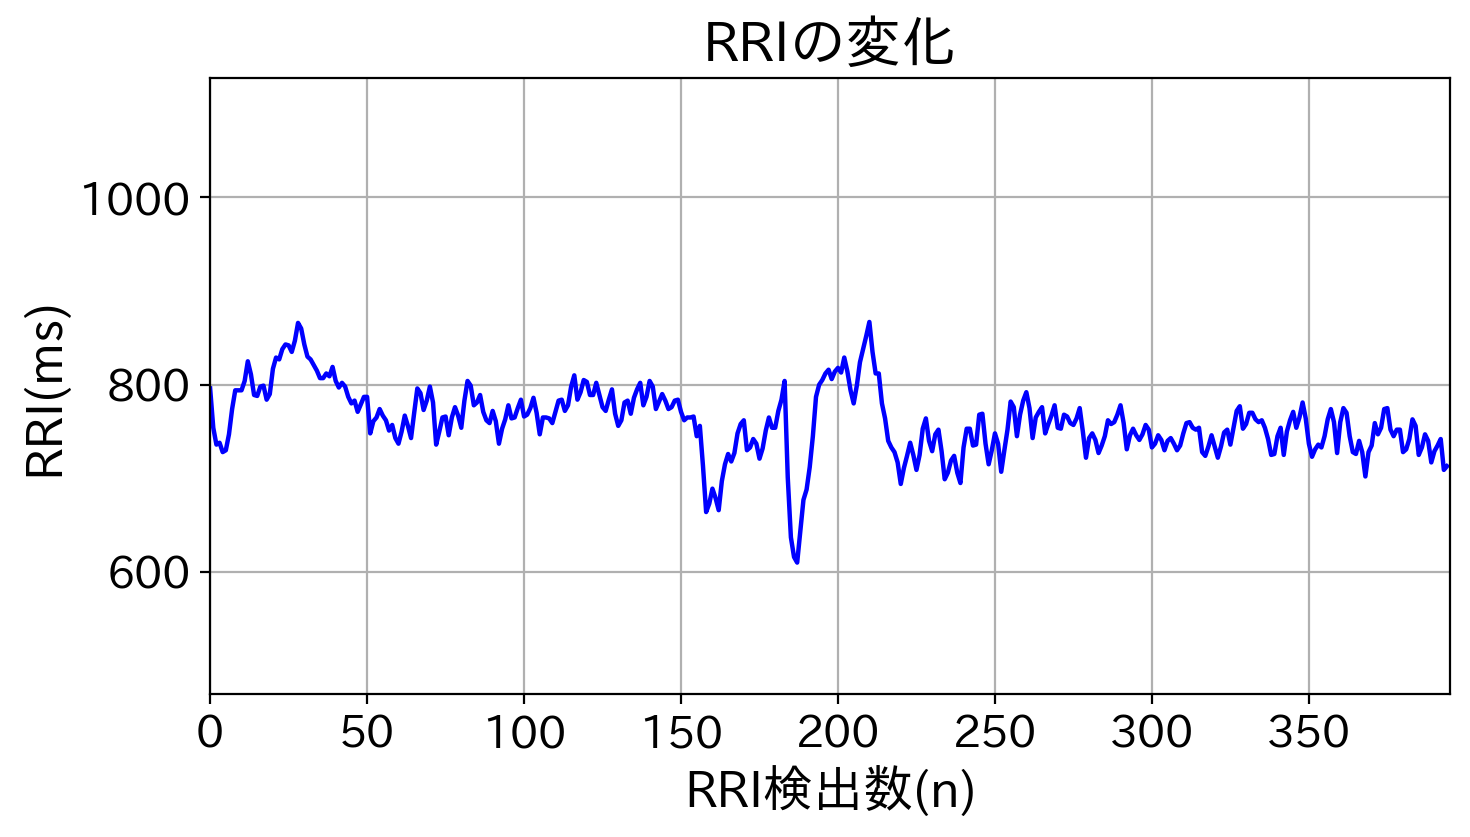

In [16]:


def plot_rri(nni):
    """
    nni (RRI in ms) を縦軸: RRI(ms), 横軸: RRI検出回数(回)として描画する。
    """
    x = range(len(nni))  # RRIの検出回数(回)
    y = nni              # RRIの値 (ms)
    
    plt.figure(figsize=(8,4))
    plt.plot(x, y, color='blue')
    plt.xlabel('RRI検出数(n)')
    plt.ylabel('RRI(ms)')
    plt.title('RRIの変化')
    plt.xlim(0, len(nni))
    plt.ylim(min(nni)/1.3, max(nni)*1.3)
    plt.grid(True)
    plt.show()

# 例: nni が既に求まっている場合
plot_rri(nni)


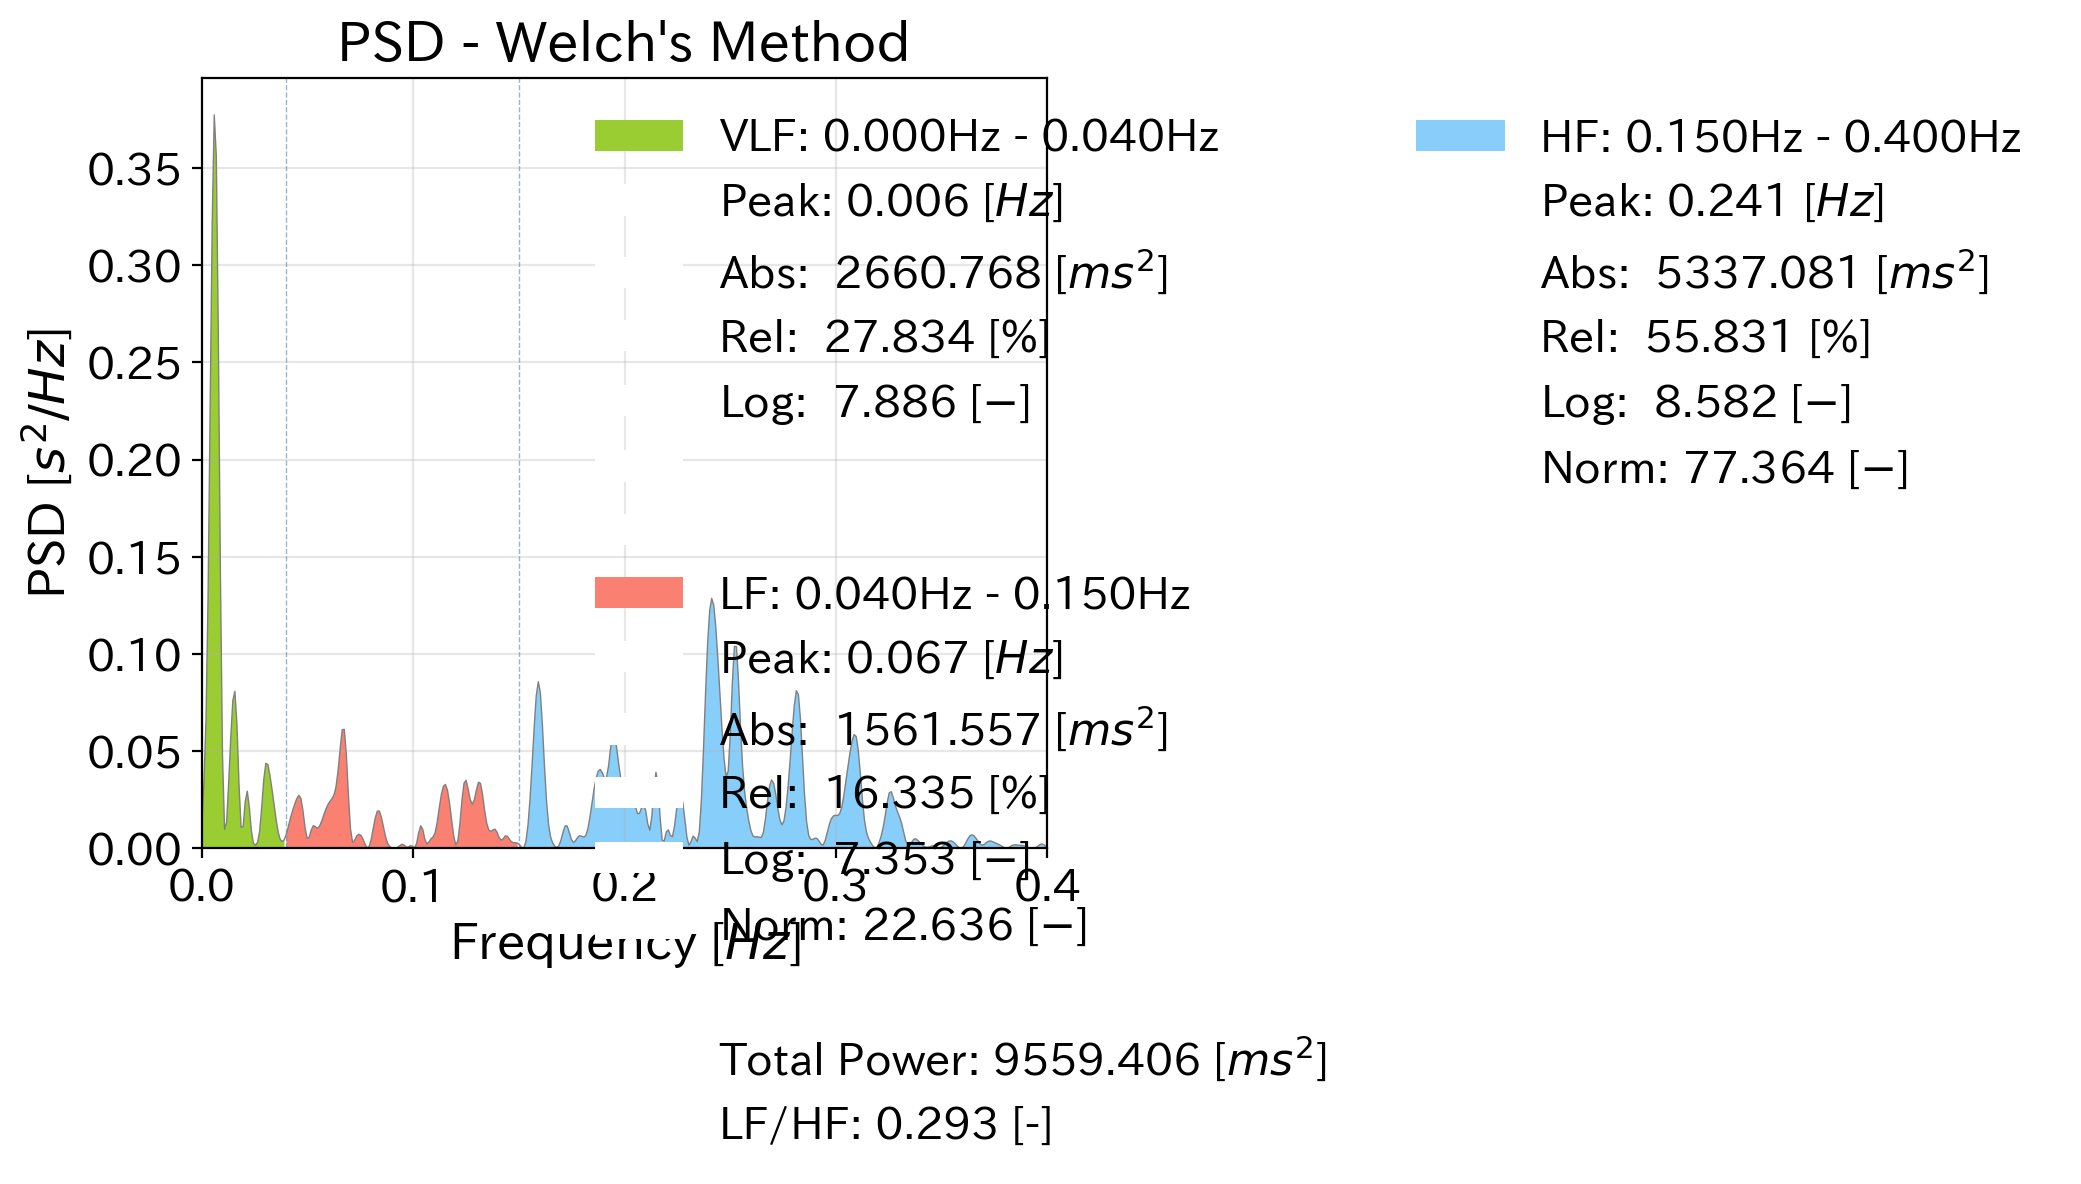

ReturnTuple(fft_bands=ReturnTuple(ulf=None, vlf=(0.0, 0.04), lf=(0.04, 0.15), hf=(0.15, 0.4)), fft_peak=(np.float64(0.005859375), np.float64(0.0673828125), np.float64(0.2412109375)), fft_abs=(np.float64(2660.7682014296), np.float64(1561.5567256403751), np.float64(5337.081162110837)), fft_rel=(np.float64(27.834032539333343), np.float64(16.335290195566866), np.float64(55.830677265099794)), fft_log=(7.88637015761169, 7.353438503722842, 8.582434183658979), fft_norm=(np.float64(22.63572535692846), np.float64(77.36427464307154)), fft_ratio=np.float64(0.29258628044224333), fft_total=np.float64(9559.406089180811), fft_plot=<Figure size 1200x500 with 2 Axes>, fft_nfft=4096, fft_window='hamming', fft_resampling_frequency=4, fft_interpolation='cubic')


In [17]:
# Import packages
import numpy as np
import pyhrv
import pyhrv.frequency_domain as fd

# Load NNI sample series
nni = pyhrv.utils.load_sample_nni()

# Compute the PSD and frequency domain parameters 
result = fd.welch_psd(nni=nni, show_param=True) # param=Trueとすると、解析結果表示

# Access peak frequencies using the key 'fft_peak'
#print(result['fft_peak'])
print(result)


In [18]:
hf_integral = result['fft_abs'][2]
print("HF integral:", hf_integral)


HF integral: 5337.081162110837
